# View the simulated spectrum of CTIO Data in January 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : January 19th 2017
- update : January 24th


This reads all the simulated fits spectra in order to build a single fits file of all simulated spectra.


In [59]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [60]:
print theNotebook

View_SimSpectrum_HD60753


In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [62]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [63]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [64]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [65]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [66]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [67]:
from IPython.display import Image, display

In [68]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [69]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [70]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [71]:

object_name='HD60753'

### Output directory for images generated in the notebook view (not true fits images)

In [72]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [73]:
ensure_dir(dir_top_images)

### Fits Output file
--------------------

- Gather the simulate spectra in a single fits file
- This is because one is limited in the number of fits file whcih can be open
- Used in a latter step.

In [74]:
outputfitsfile='AllSimSpectra_'+object_name+'.fits'

In [75]:
#ensure_dir(outputdir)

### Input fits file
-----------------
- Location of the simulated spectra for the dataset

In [76]:
#simspecdir='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01'
simspecdir='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_19/HD60753-focus-R200'

In [77]:
!pwd

/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/2017_01_19/HD60753-focus-R200


## Read the simulated spectra

In [78]:
inputsim_filelist=os.listdir(simspecdir) 

In [79]:
if '.DS_Store' in inputsim_filelist:
    inputsim_filelist.remove('.DS_Store')
inputsim_filelist=np.array(inputsim_filelist)

In [80]:
print inputsim_filelist[0:5]

['RT_CT_pp_us_sa_rt_HD60753_Nev481_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD60753_Nev482_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD60753_Nev483_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD60753_Nev484_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD60753_Nev485_y2016_m01_aver_spectra.fits']


In [81]:
print re.findall('^RT_CT_pp_us_sa_rt_HD14943_Nev(.*)_y2016_m01_aver_spectra.fits',inputsim_filelist[0])

[]


In [82]:
indexes_simfiles= [] # global list
filelist_simfitspec= []  # global list

In [83]:
#%%cython

import numpy as np
import re

def MakeSimFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                index=index+1
                filelist_fitsimages.append(filename)
                str_num=re.findall('^RT_CT_pp_us_sa_rt_HD60753_Nev(.*)_y2016_m01_aver_spectra.fits',file)
                number=int(str_num[0])
                indexes_files.append(number)
    return indexes_files, filelist_fitsimages

In [84]:
indexes_simfiles, filelist_simfitspec=MakeSimFileList(simspecdir,inputsim_filelist)   # filter to take only fits file

In [85]:
# transform into numpy arrays
indexes_simfiles=np.array(indexes_simfiles)
filelist_simfitspec=np.array(filelist_simfitspec)

In [86]:
print indexes_simfiles

[481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498]


In [87]:
sorted_simindexes=np.argsort(indexes_simfiles) # sort the file indexes

In [88]:
sorted_simindexes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [89]:
sorted_simnumbers=indexes_simfiles[sorted_simindexes] # check the ordering with argsort is correct

In [90]:
print sorted_simnumbers # check

[481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498]


In [91]:
sorted_simfiles=filelist_simfitspec[sorted_simindexes] # now sort the filenames

In [92]:
print sorted_simfiles[0:5] # check

[ '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_19/HD60753-focus-R200/RT_CT_pp_us_sa_rt_HD60753_Nev481_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_19/HD60753-focus-R200/RT_CT_pp_us_sa_rt_HD60753_Nev482_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_19/HD60753-focus-R200/RT_CT_pp_us_sa_rt_HD60753_Nev483_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_19/HD60753-focus-R200/RT_CT_pp_us_sa_rt_HD60753_Nev484_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_19/HD60753-focus-R200/RT_CT_pp_us_sa_rt_HD60753_Nev485_y2016_m01_aver_spectra.fits']


In [93]:
hdu_list=fits.open(sorted_simfiles[0])
header=hdu_list[0].header

In [94]:
print header

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  OBJ_NAME= 'HD60753 '                                                            AIRMASS =    1.077999949455261                                                  UNITS   = 'wavelength in nm'                                                    DATE    = '2017-01-20T05:00:23.065'                                             EXPOSURE=                 60.0                                                  FILENAME= 'trim_20170119_481.fits'                                              COMMENT Prediction of observable SPECTRA                                        END                                                                                                                     

In [95]:
 table_data=hdu_list[1].data

In [96]:
print table_data.columns

ColDefs(
    name = 'WAVELENGTH'; format = 'E'
    name = 'SEDcalspec'; format = 'E'
    name = 'Atmosphere'; format = 'E'
    name = 'QE'; format = 'E'
    name = 'SEDxQExATM'; format = 'E'
)


In [97]:
simwavelength = table_data.field('WAVELENGTH')
simsed        = table_data.field('SEDcalspec')
simatm        = table_data.field('Atmosphere')
simqe         = table_data.field('QE')
simspectra    = table_data.field('SEDxQExATM')

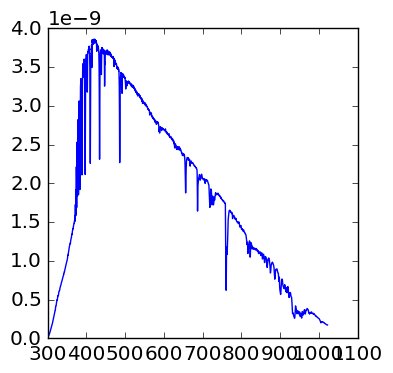

In [98]:
plt.plot(simwavelength,simspectra )

In [99]:
#%%cython

#import numpy as np
#from astropy.io import fits
def BuildSimSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildSimSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    
    all_simwavelength = []
    all_simspectra = []
    all_simatmosphere = []
    all_simqe = []
    all_simsed = []
    
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        

        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
                
        #print header
        date_obs = header['DATE']
        airmass = header['AIRMASS']
        expo = header['EXPOSURE']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        simwavelength = table_data.field('WAVELENGTH')
        simsed        = table_data.field('SEDcalspec')
        simatm        = table_data.field('Atmosphere')
        simqe         = table_data.field('QE')
        simspectra    = table_data.field('SEDxQExATM')
        
        
        all_simwavelength.append(simwavelength)
        all_simspectra.append(simspectra)
        all_simatmosphere.append(simatm)
        all_simqe.append(simqe)
        all_simsed.append(simsed)
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
            
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed

In [100]:
all_simdates,all_simairmass,all_simtitles,all_simheader,all_simexpo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed=BuildSimSpec(sorted_simfiles,sorted_simnumbers,object_name)

In [101]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowSpectra(all_wavelength,all_simspec,all_simtitles,object_name,dir_top_images):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_simspec)
    MAXIMGROW=int(NBIMAGES/4)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,4,figsize=(25,20))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%4
        iy=index/4
        wavelength=all_wavelength[index]
        spectrum=all_simspec[index]
        axarr[iy,ix].plot(wavelength,spectrum,'r-',lw=2)
        axarr[iy,ix].set_title(all_simtitles[index])
        #axarr[iy,ix].set_ylim(0.,200.)
        axarr[iy,ix].grid(True)
      
    title='simulated spectra spectra'
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'simulatedspectra.pdf')
    plt.savefig(figfilename)         

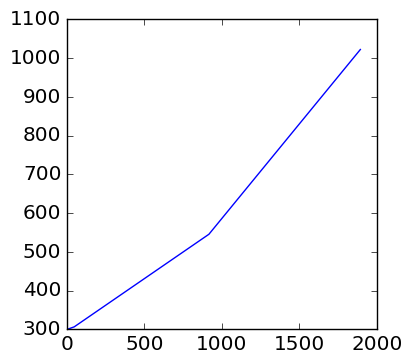

In [102]:
plt.plot(all_simwavelength[1])

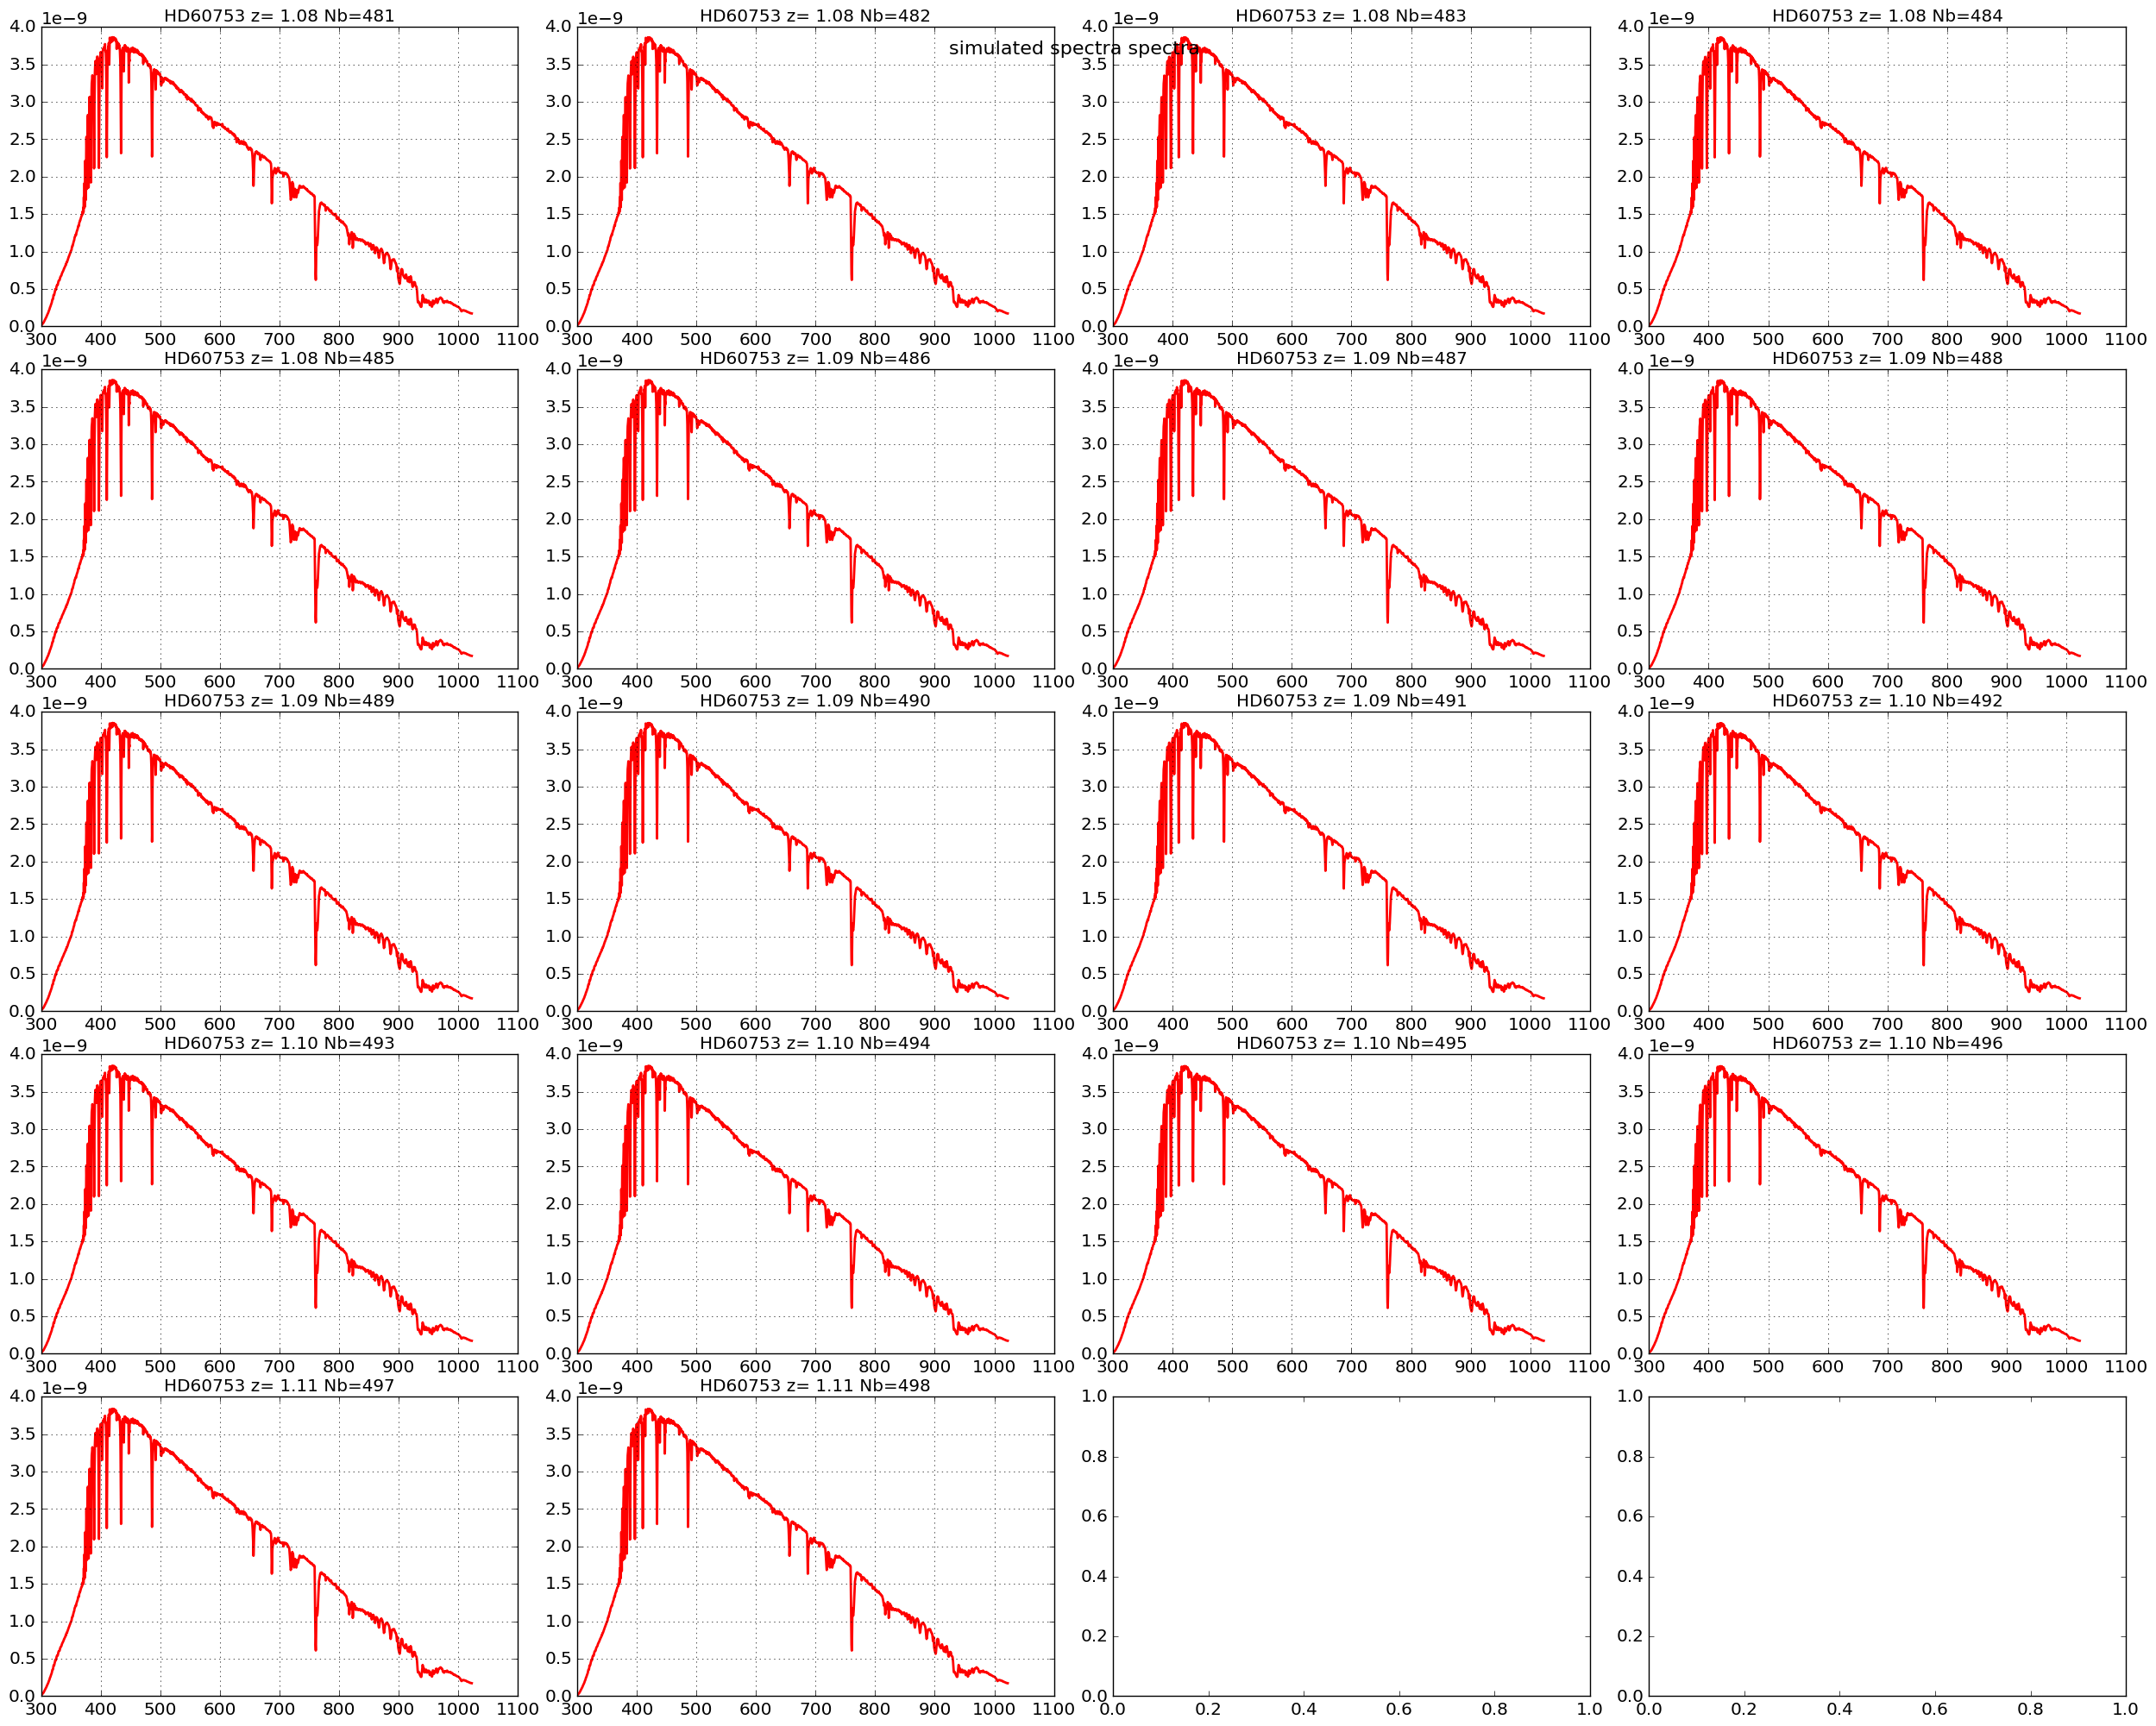

In [103]:
ShowSpectra(all_simwavelength,all_simspectra,all_simtitles,object_name,dir_top_images)

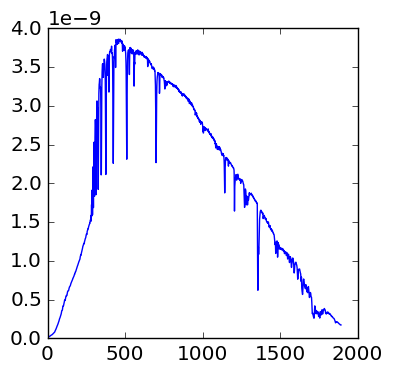

In [104]:
plt.plot(all_simspectra[0])

In [105]:
len(all_simwavelength[0])

1894

In [106]:
def MakeSimNpArray(all_simwavelength,all_simspectra):
    
    all_simspectra=np.array(all_simspectra)
    simwavelength=np.array(all_simwavelength[0])
    
    NBSPEC=all_simspectra.shape[0]
    NBWL=simwavelength.shape[0]
    
    print NBSPEC,' , ',NBWL
    dataout=np.zeros((NBSPEC+1,NBWL))
    
    dataout[0,:]=simwavelength
    
    for ispec in np.arange(1,NBSPEC+1):
        dataout[ispec,:]=all_simspectra[ispec-1]
    return dataout
    

In [107]:
spectra_out=MakeSimNpArray(all_simwavelength,all_simspectra)

18  ,  1894


In [108]:
spectra_out.shape

(19, 1894)

In [109]:
spectra_out[0,:]

array([  300.01486206,   300.15185547,   300.28884888, ...,  1021.45147705,
        1021.93859863,  1022.42565918])

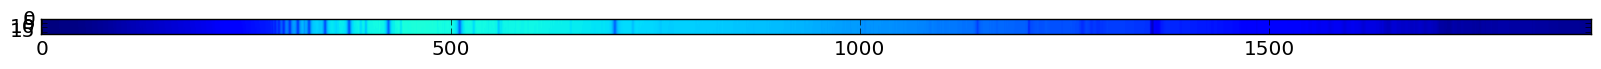

In [110]:
plt.figure(figsize=(20,20))
plt.imshow(spectra_out[:,:],vmin=0,vmax=1e-8)

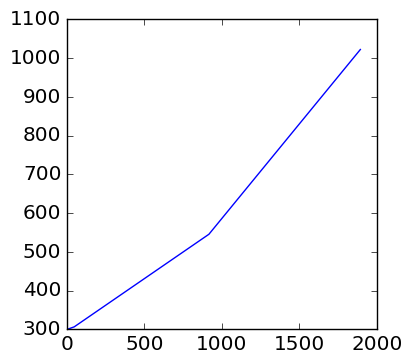

In [111]:
plt.plot(spectra_out[0,:])

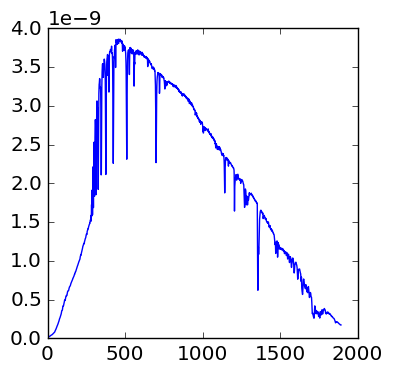

In [112]:
plt.plot(spectra_out[1,:])

### Save output fits file

In [113]:
prihdu = fits.PrimaryHDU(data=spectra_out)
thdulist = fits.HDUList(prihdu)
thdulist.writeto(outputfitsfile,clobber=True)